# <center> S&P 500 Index Prediction with LSTM <center>
    
The science of forecasting stock prices has been a difficult task for many of the researchers and analysts. In fact, investors are highly interested in the research area of stock price prediction. Good and effective prediction systems could help tremendeously for the short term investment like Options trading. In this work, I used a recurrent neural network (RNN) and Long Short-Term Memory (LSTM) approach to predict S&P 500 index.


Long Short Term Memory cells are like mini neural networks designed to allow for memory in a larger neural network. This is achieved through the use of a recurrent node inside the LSTM cell. This node has an edge looping back on itself with a weight of one, meaning at every feedfoward iteration the cell can hold onto information from the previous step, as well as all previous steps. Since the looping connection’s weight is one, old memories wont fade over time like they would in traditional RNNs.

LTSMs and recurrent neural networks are as a result good at working with time series data thanks to their ability to remember the past. By storing some of the old state in these recurrent nodes, RNNs and LSTMs can reason about current information as well as information the network had seen one, ten or a thousand steps ago. Even better, I don’t have to write my own implementation of an LSTM cell; they’re a default layer in Tensorflow’s Keras.

## Import the necessary libraries

In [42]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
from datetime import datetime

## Getting the data
Used pandas_datareader to get the data from Yahoo Finance.


In [92]:
# Get the S&P 500 data from Yahoo Finance and store in a dataframe

gspc_idx = data.DataReader('^GSPC',  'yahoo', datetime(1990, 1, 1), datetime.today())
print(gspc_idx.head())

                  High         Low        Open       Close     Volume  \
Date                                                                    
1990-01-02  359.690002  351.980011  353.399994  359.690002  162070000   
1990-01-03  360.589996  357.890015  359.690002  358.760010  192330000   
1990-01-04  358.760010  352.890015  358.760010  355.670013  177000000   
1990-01-05  355.670013  351.350006  355.670013  352.200012  158530000   
1990-01-08  354.239990  350.540009  352.200012  353.790009  140110000   

             Adj Close  
Date                    
1990-01-02  359.690002  
1990-01-03  358.760010  
1990-01-04  355.670013  
1990-01-05  352.200012  
1990-01-08  353.790009  


## Explore & Clean the data

### Check for the missing values

As per the below results there is no missing value in the dataset 

In [93]:
gspc_idx.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

### Check the outlier in the input dataset

In [94]:
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":9,"axes.titlesize":16,"axes.labelsize":14, "axes.titleweight":'bold'})

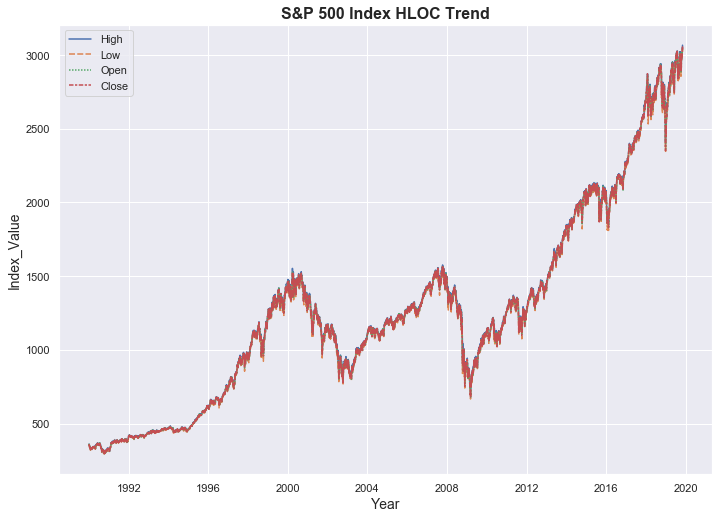

In [97]:
s= sns.lineplot(data=gspc_idx.iloc[:,:4]).set(title = "S&P 500 Index HLOC Trend", xlabel="Year", ylabel= "Index_Value")

From the graph below it looks like there is an outlier in the 'Volume' value on 10/31. Since the value looks incorrect, replacing the previous day value


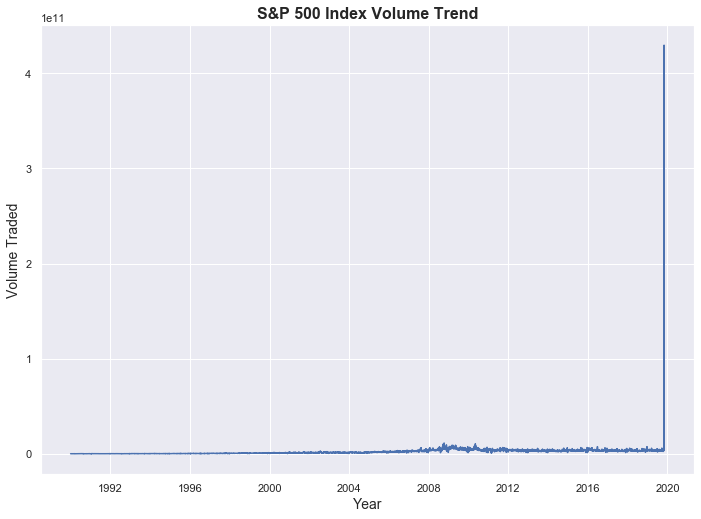

In [98]:
s= sns.lineplot(data=gspc_idx.iloc[:,4]).set(title = "S&P 500 Index Volume Trend", xlabel="Year", ylabel= "Volume Traded")

#### Handling outlier in the 'Volume' on 10/31/2019

Since the volume traded on 10/31/2019 is nearly 50 times the normal volume, We could confirm it as an outlier. The volume traded on 10/30/2019 is used to forward fill the the volume on 10/31/2019

In [99]:
gspc_idx.loc["2019-10-31","Volume"] = gspc_idx.loc["2019-10-30","Volume"]

#### Volume feature after fixing the outlier

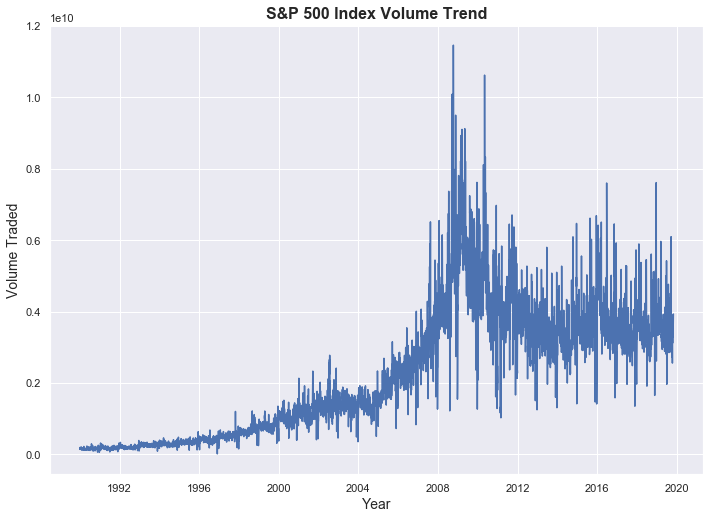

In [90]:
s= sns.lineplot(data=gspc_idx.iloc[:,4]).set(title = "S&P 500 Index Volume Trend", xlabel="Year", ylabel= "Volume Traded")

## Feature selection

<B>Removing the date index:</B>  Since the data is already sorted in datetime order, the date values in the index doesn't provide much information in model providing.

In [100]:
gspc_idx_cln = gspc_idx.reset_index(drop=True)
print(gspc_idx_cln.head())
print(gspc_idx_cln.shape)

         High         Low        Open       Close       Volume   Adj Close
0  359.690002  351.980011  353.399994  359.690002  162070000.0  359.690002
1  360.589996  357.890015  359.690002  358.760010  192330000.0  358.760010
2  358.760010  352.890015  358.760010  355.670013  177000000.0  355.670013
3  355.670013  351.350006  355.670013  352.200012  158530000.0  352.200012
4  354.239990  350.540009  352.200012  353.790009  140110000.0  353.790009
(7519, 6)


<b>Dropping the 'Adj Close' feature:</b> As the 'Close' column and 'Adj Close' column has almost same information, dropping the 'Adj Close' feature 

In [101]:
gspc_idx_cln = gspc_idx_cln.iloc[:,:5]
print(gspc_idx_cln.head())
print(gspc_idx_cln.shape)

         High         Low        Open       Close       Volume
0  359.690002  351.980011  353.399994  359.690002  162070000.0
1  360.589996  357.890015  359.690002  358.760010  192330000.0
2  358.760010  352.890015  358.760010  355.670013  177000000.0
3  355.670013  351.350006  355.670013  352.200012  158530000.0
4  354.239990  350.540009  352.200012  353.790009  140110000.0
(7519, 5)


## Feature Scaling

Most of the machinelearning models converge fast when the features are scaled. The selected features are scaled between values 1 and 0

### MinMaxScaler 
- For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.
- MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.
- Note that MinMaxScaler doesn’t reduce the importance of outliers.
- The default range for the feature returned by MinMaxScaler is 0 to 1.

In [104]:
# Feature Scaling Normalization

data_normaliser = preprocessing.MinMaxScaler()
gspc_norm = data_normaliser.fit_transform(gspc_idx_cln)

print(gspc_norm[0:60,0])


[0.02105948 0.02138492 0.0207232  0.01960586 0.01908876 0.01906346
 0.01741818 0.01760622 0.01702404 0.01391791 0.01421081 0.01466643
 0.01335382 0.01411318 0.01392514 0.01132164 0.01094196 0.01116615
 0.00981015 0.00935093 0.00877961 0.00999095 0.010273   0.01108298
 0.01110468 0.01099619 0.01168324 0.01252576 0.01198698 0.01163261
 0.01090579 0.01148075 0.01220755 0.01236305 0.01130717 0.00966191
 0.010678   0.00893147 0.00984271 0.01102513 0.01158199 0.01191466
 0.01232688 0.01263063 0.0131911  0.01352015 0.01417827 0.01403724
 0.01360693 0.01345869 0.01308262 0.01354547 0.01463026 0.01529922
 0.01556318 0.01478575 0.01385644 0.01306454 0.01384559 0.01448201]


In [103]:
# Creating dataset with 60 timesteps and 1 output

X_train = []
y_train = []

for i in range(60, 7518):
    X_train.append(gspc_norm[i-60:i,0])
    y_train.append(gspc_norm[i, 0])
print(X_train[:10])

print(y_train[:10])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train[:10])

print(y_train[:10])

[array([0.02105948, 0.02138492, 0.0207232 , 0.01960586, 0.01908876,
       0.01906346, 0.01741818, 0.01760622, 0.01702404, 0.01391791,
       0.01421081, 0.01466643, 0.01335382, 0.01411318, 0.01392514,
       0.01132164, 0.01094196, 0.01116615, 0.00981015, 0.00935093,
       0.00877961, 0.00999095, 0.010273  , 0.01108298, 0.01110468,
       0.01099619, 0.01168324, 0.01252576, 0.01198698, 0.01163261,
       0.01090579, 0.01148075, 0.01220755, 0.01236305, 0.01130717,
       0.00966191, 0.010678  , 0.00893147, 0.00984271, 0.01102513,
       0.01158199, 0.01191466, 0.01232688, 0.01263063, 0.0131911 ,
       0.01352015, 0.01417827, 0.01403724, 0.01360693, 0.01345869,
       0.01308262, 0.01354547, 0.01463026, 0.01529922, 0.01556318,
       0.01478575, 0.01385644, 0.01306454, 0.01384559, 0.01448201]), array([0.02138492, 0.0207232 , 0.01960586, 0.01908876, 0.01906346,
       0.01741818, 0.01760622, 0.01702404, 0.01391791, 0.01421081,
       0.01466643, 0.01335382, 0.01411318, 0.01392514, 0.01

In [8]:
data = gspc_idx_cln[:5]
print(data)
scaler = preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print(scaled_data)


         High         Low        Open       Close     Volume   Adj Close
0  359.690002  351.980011  353.399994  359.690002  162070000  359.690002
1  360.589996  357.890015  359.690002  358.760010  192330000  358.760010
2  358.760010  352.890015  358.760010  355.670013  177000000  355.670013
3  355.670013  351.350006  355.670013  352.200012  158530000  352.200012
4  354.239990  350.540009  352.200012  353.790009  140110000  353.790009
[[0.85826881 0.19591854 0.16021138 1.         0.42052853 1.        ]
 [1.         1.         1.         0.87583526 1.         0.87583526]
 [0.71181342 0.31972846 0.87583526 0.46328515 0.70643432 0.46328515]
 [0.22520029 0.11020366 0.46328515 0.         0.35273841 0.        ]
 [0.         0.         0.         0.21228283 0.         0.21228283]]


C:\Users\Ishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
